# El problema

Vamos a tratar de entender cómo funciona SVM y a utilizarlo para clasificar caras.

Comencemos con un ejemplo básico. Para ello, primero realizaremos los imports necesarios:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Data

Vamos a utilizar un conjunto de datos sintético generado con `make_blobs`:

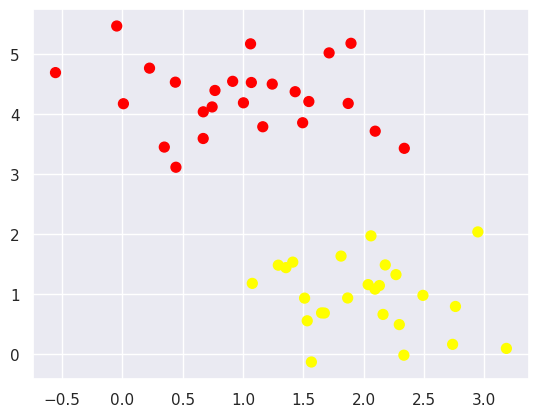

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Si quisieramos encontrar una frontera de separación entre ambos conjuntos de datos, lo más intuitivo sería utilizar aquella que mejor los separe, ¿verdad?

A continuación podéis ver un ejemplo donde dibujamos varias rectas que separarían los datos anteriores, pero fijaos en lo que ocurriría cuando nos llega un nuevo dato: dependiendo de la frontera que hubiéramos elegido la clasificaríamos bien o no.

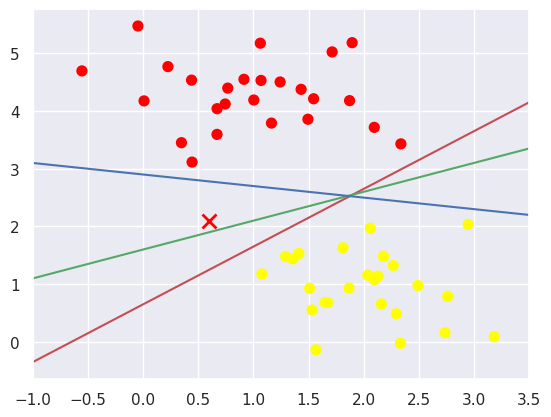

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b, c in [(1, 0.65, 'r'), (0.5, 1.6, 'g'), (-0.2, 2.9, 'b')]:
    plt.plot(xfit, m * xfit + b, f'-{c}')

plt.xlim(-1, 3.5);

Todas las rectas separan correctamente los datos de entrenamiento, pero no todas funcionan bien con la nueva muestra.

Vamos a ver cómo podemos obtener automáticamente la mejor recta de separación (frontera).

## Support Vector Machines: Maximizando el margen*

Lo que pretende SVM es encontrar, en lugar de una línea, una "banda" de un determinado ancho que separe las muestras.

Fijaos en este ejemplo:

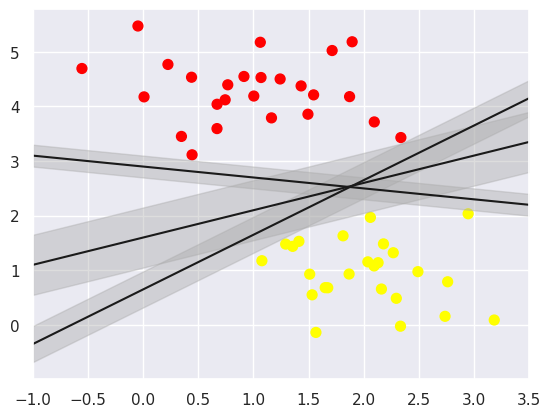

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

En SVM, la línea cuya "banda" sea más ancha es la frontera que escogeremos. Es decir, estamos hablando de estimadores de máximo margen.

### Ajuste de un SVM



In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

Vamos a visualizarlo:

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

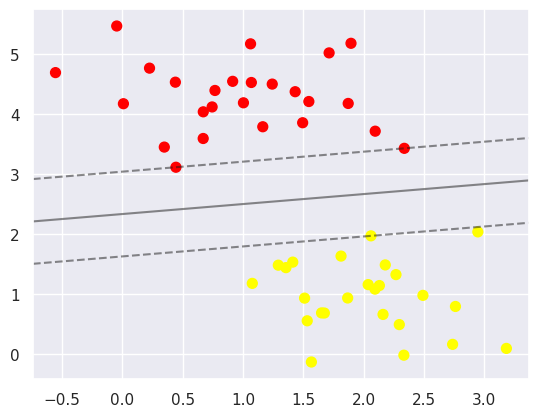

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

Ésta es la línea divisoria que maximiza el margen entre los dos conjuntos de puntos.

Observad que algunos de los puntos de entrenamiento solo tocan el margen: estos puntos son los elementos fundamentales de este ajuste, se conocen como vectores de soporte, y dan nombre al algoritmo.

En Scikit-Learn, la identidad de estos puntos se almacena en el atributo ``support_vectors_`` del clasificador:

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Una clave del éxito de este clasificador es que para el ajuste solo importa la posición de los vectores de soporte. Es decir, **cualquier punto más alejado del margen que esté en el lado correcto no modifica el ajuste**.

Técnicamente, esto se debe a que estos puntos no contribuyen a la función de pérdidas utilizada para ajustar el modelo, por lo que su posición y número no importan siempre que no crucen el margen.

Podemos ver esto, por ejemplo, si mostramos el resultado del modelo aprendido con los primeros 60 puntos y 120 puntos de este conjunto de datos:

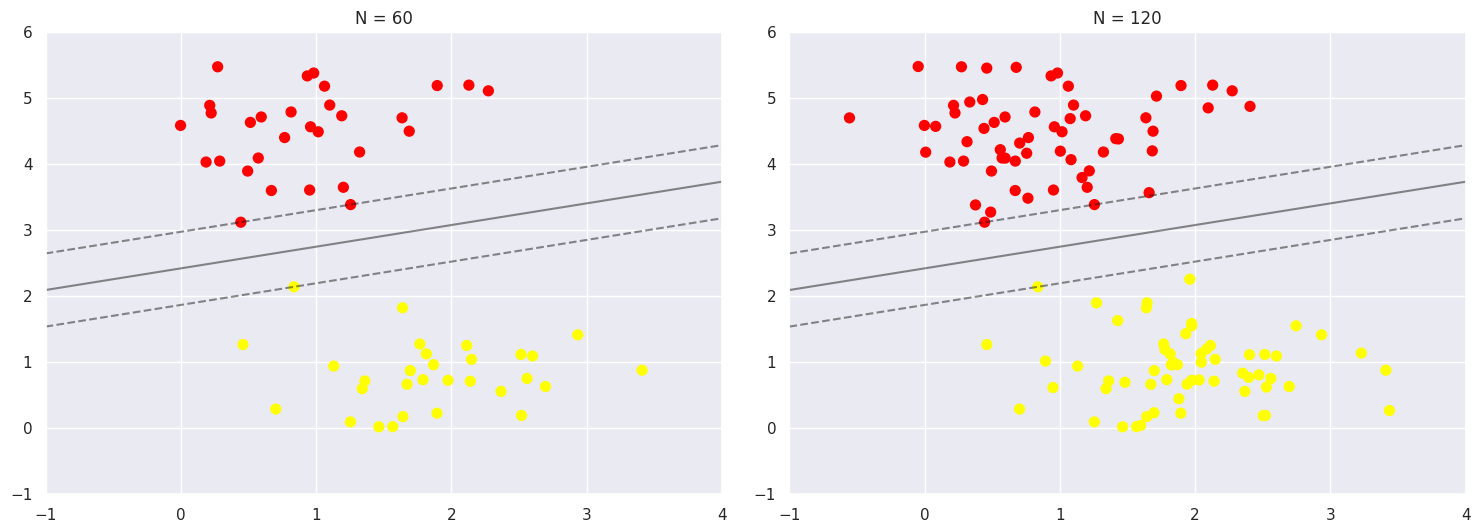

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

A la izquierda vemos el modelo y los vectores de soporte para 60 puntos de entrenamiento.

A la derecha, hemos duplicado el número de puntos de entrenamiento, pero el modelo no ha cambiado: los tres vectores de apoyo del panel izquierdo siguen siendo los vectores de apoyo del panel derecho.

**Esta insensibilidad al comportamiento exacto de puntos distantes es uno de los puntos fuertes del modelo SVM.**

Vamos a jugar un poco:

interactive(children=(Dropdown(description='N', options=(10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 13…

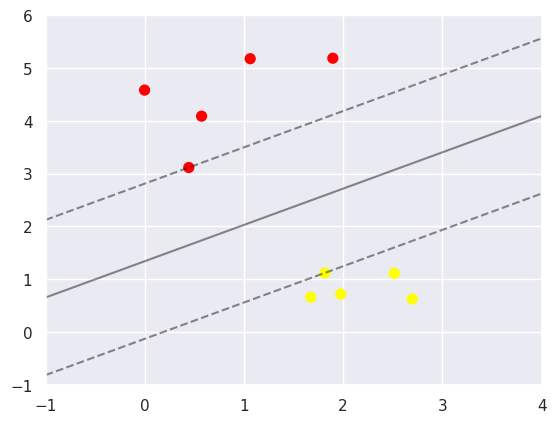

In [10]:
from ipywidgets import interact, fixed
interact(plot_svm, N=range(10, 200, 10), ax=fixed(None));

### ¿Y si los datos no fuesen linealmente separables? -> KERNEL SVM

**La combinación de Kernels y SVM hacen de éste un algoritmo muy potente.**

Gracias a los kernels vamos a poder transformar los datos de forma que sí sean separables linealmente. Fijaos en este ejemplo:

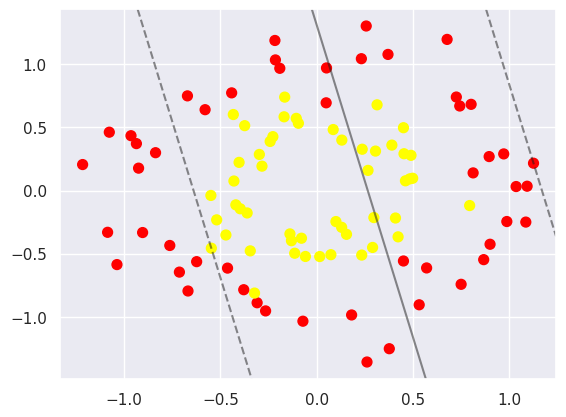

In [11]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.5, noise=.15)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Está claro que con un SVM lineal no vamos a poder separarlos bien. Pero si utilizamos un **radial basis function** como kernel, de forma que transformemos los datos a un espacio más altamente dimensional, sí podremos.

Veamoslo:

In [12]:
r = (X ** 2).sum(1) # Kernel polinómico

In [13]:
r = np.exp(-(X ** 2).sum(1)) # Kernel gaussiano

interactive(children=(IntSlider(value=30, description='elev', max=90, min=-90), IntSlider(value=30, descriptio…

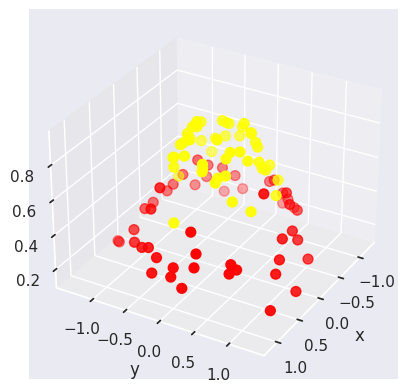

In [14]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=(-90, 90), azip=(-180, 180),
         X=fixed(X), y=fixed(y));

Podemos ver que con esta dimensión adicional, los datos se vuelven linealmente separables y nos bastaría con un plano de separación en r = 0,7, por ejemplo.

Vamos a ver qué tal funciona la clasificación usando el kernel 'rbf':

In [15]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

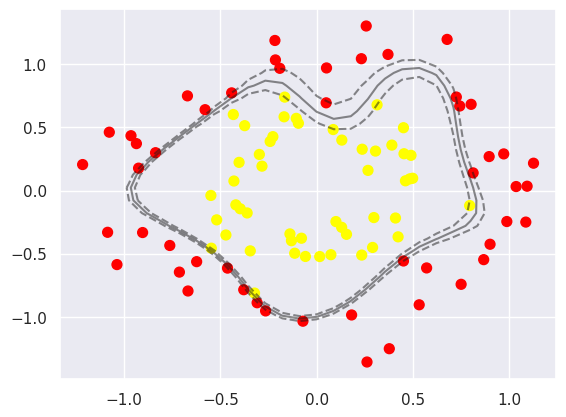

In [16]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

¡Fijaos que hemos conseguido separar correctamente todos los puntos!

## Ejemplo: Reconocimiento facial

Vamos a usar el Labeled Faces in the Wild dataset, que consiste en varios miles de imágenes de personas famosas "in the wild", es decir, sin estar en un entorno controlado, y vamos a tratar de identificar quién es quién.

In [17]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Veamos unas pocas:

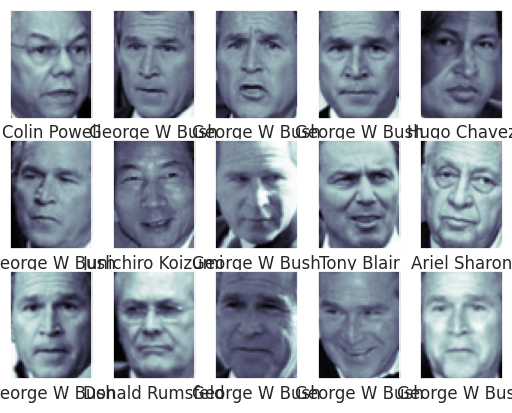

In [18]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Cada imagen contiene [62×47] pixels, es decir, casi 3000. Por lo tanto, tendríamos casi 3000 variables (dimensiones).

Como ya sabemos, la maldición de la dimensionalidad hace que para datos con muchas dimensiones las medidas de distancia no funcionen muy bien, así que vamos a reducir las dimensiones a 150 mediante PCA:

In [19]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Dividimos en train y test:

In [20]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,random_state=42)

Y hacemos un grid search para obtener los mejores parámetros posibles de C y gamma. C sería la penalización por cada elemento mal clasificado (c alta implica márgenes más pequeños). Gamma, en el caso del kernel gaussiano, controla la distancia de influencia de cada ejemplo de entrenamiento para que se junten tras transformarse.

In [21]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 3s, sys: 44 s, total: 1min 47s
Wall time: 1min 23s
{'svc__C': 5, 'svc__gamma': 0.001}


Vamos ahora a utilizar el mejor modelo para predecir el test:

In [22]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Veamos qué tal ha ido:

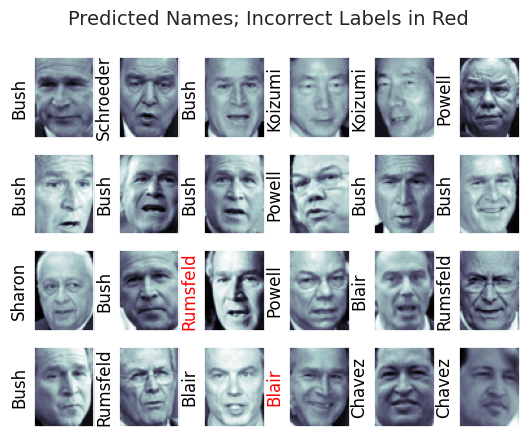

In [23]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Como podemos observar, la única cara que ha sido mal predicha es la de Bush, que ha predicho como Blair. Vamos a ver un report con las métricas para cada cara:

In [24]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



Y la matriz de confusión:

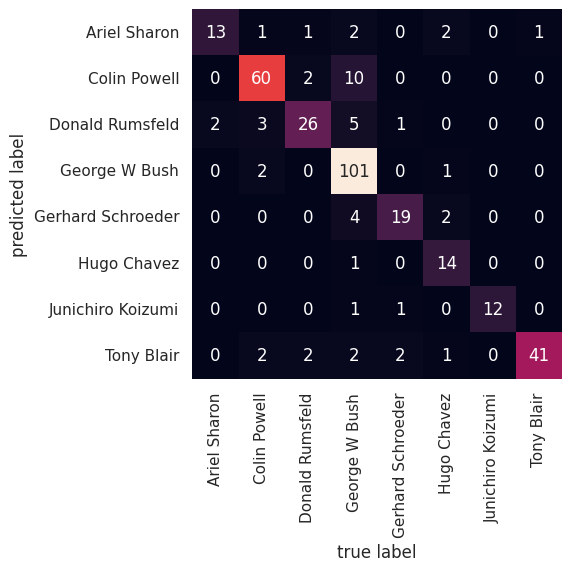

In [25]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

¡Fijaos que no está nada mal!

### Fuente y más recursos:

- https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

- https://towardsdatascience.com/support-vector-machine-python-example-d67d9b63f1c8
- https://ipython-books.github.io/85-using-support-vector-machines-for-classification-tasks/
- https://notebook.community/dcavar/python-tutorial-for-ipython/notebooks/Python%20SVM%20Classifier%20Example

